# Integration of snRNA and scRNA data

In this notebook snRNA and scRNA data is integrated into one latent space. To construct a common latent space for both measurements we are using `scVI` in this notebook

**Requires:**
- `/vol/storage/data/pancreas_multiome/processed/gex_e15.5.h5ad`
- `/vol/storage/data/pancreas_sc/processed/gex_e15.5.h5ad`
- `/vol/storage/data/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz` (downloadable from ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz)

**Output:**
- `/vol/storage/data/pancreas_sc_multiome/sn_sc_rna_scvi.h5ad`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import mplscience
import scvi

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scvelo as scv

sys.path.append("../..")
from paths import FIG_DIR, PROJECT_DIR  # isort: skip  # noqa: E402

/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-

## General settings

In [3]:
SAVE_FIGURES = True
SAVE_MODEL = True
SN_PROCESSED_DIR = PROJECT_DIR / "pancreas_multiome" / "processed"
SC_PROCESSED_DIR = PROJECT_DIR / "pancreas_sc" / "processed"

sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

celltype_colors = {
    "celltype_colors": {
        "Alpha": "#1f78b4",
        "Beta": "#b2df8a",
        "Delta": "#6a3d9a",
        "Ductal": "#8fbc8f",
        "Epsilon": "#cab2d6",
        "Ngn3 high EP": "#fdbf6f",
        "Ngn3 low EP": "#f4a460",
        "Pre-endocrine": "#ff7f00",
    },
    "celltype_fine_colors": {
        "Alpha": "#1f78b4",
        "Beta": "#b2df8a",
        "Delta": "#6a3d9a",
        "Ductal": "#8fbc8f",
        "Eps/Delta progenitors": "#029e73",
        "Epsilon": "#cab2d6",
        "Ngn3 high EP": "#fdbf6f",
        "Ngn3 low EP": "#f4a460",
        "Fev+ Alpha": "#d55e00",
        "Fev+ Beta": "#cc78bc",
        "Fev+ Delta": "#ca9161",
    },
}

protocol_colors = {"scRNA-seq": "#0173b2", "multiome": "#de8f05"}

## Read and preprocess GEX data

In [4]:
adata_sn = sc.read(SN_PROCESSED_DIR / "gex_e15.5.h5ad")
adata_sc = sc.read(SC_PROCESSED_DIR / "gex_e15.5.h5ad")

adata = adata_sn.concatenate(adata_sc)
adata.layers["counts"] = adata.layers["spliced"] + adata.layers["unspliced"]

scv.pp.filter_genes(adata, min_counts=20)
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="protocol",
    subset=True,
)
adata

AnnData object with n_obs × n_vars = 8412 × 2000
    obs: 'day', 'celltype', 'n_counts', 'celltype_fine', 'protocol', 'batch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'spliced', 'unspliced', 'counts'

## Train scvi model to get common latent space

In [5]:
scvi.model.SCVI.setup_anndata(adata, batch_key="batch", layer="counts")  # model requires raw counts

vae = scvi.model.SCVI(adata, n_layers=4, n_latent=30, gene_likelihood="nb")  # Negative binomial distribution

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
vae.train(early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 262/400:  66%|███▉  | 262/400 [05:12<02:44,  1.19s/it, v_num=1, train_loss_step=1.25e+3, train_loss_epoch=1.26e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1275.357. Signaling Trainer to stop.


## Get latent representation and plot UMAP

computing neighbors
    finished (0:00:36) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


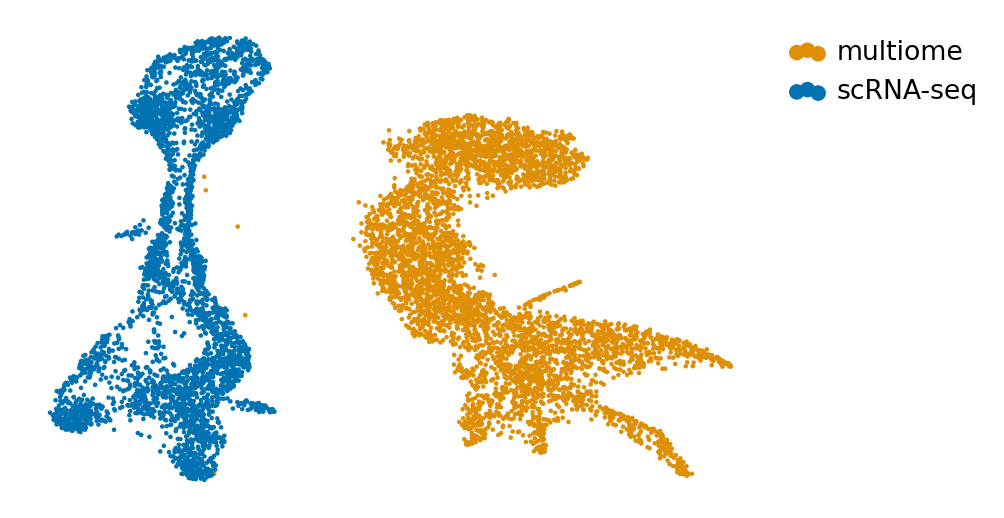

In [7]:
# first plot unintegrated data
scv.pp.pca(adata)
scv.pp.neighbors(adata)
scv.tl.umap(adata)

adata.uns["celltype_colors"] = celltype_colors["celltype_colors"]
adata.uns["protocol_colors"] = protocol_colors

with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.umap(adata, color="protocol", ax=ax, title="")
    plt.show()
    if SAVE_FIGURES:
        path = FIG_DIR / "data_integration"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(path / "unintegrated_umap_protocol_e15.5.svg", format="svg", transparent=True, bbox_inches="tight")

In [8]:
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=25)

sc.tl.umap(adata)

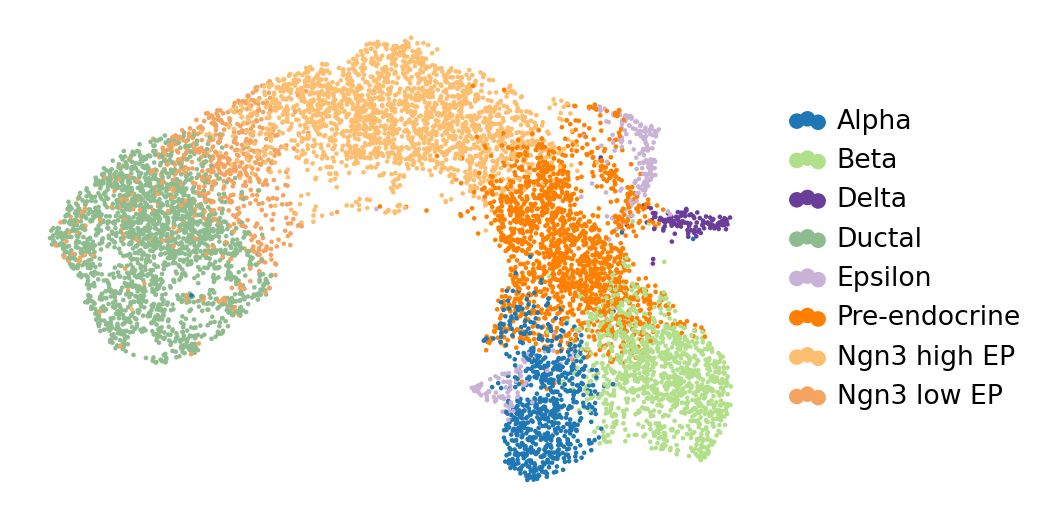

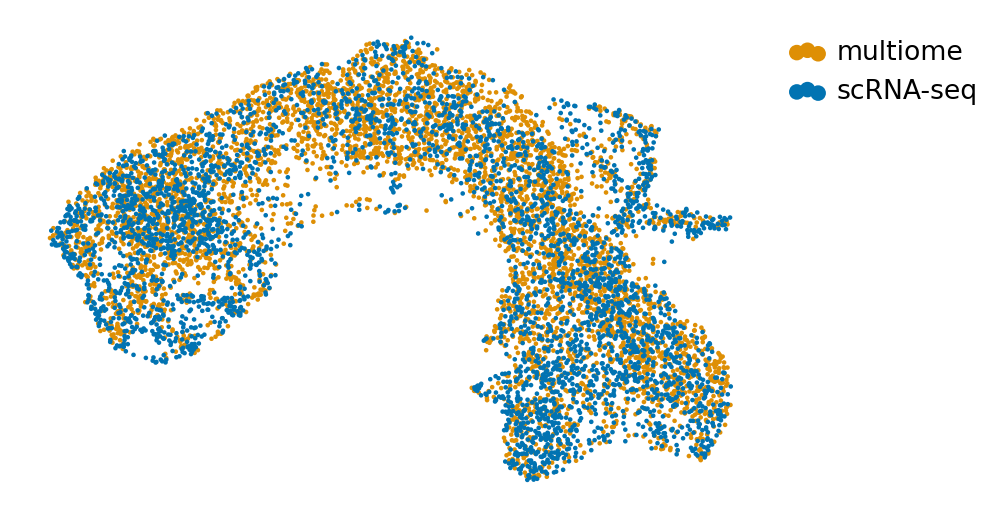

In [9]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.umap(adata, color="celltype", ax=ax, legend_loc="right margin", title="")
    plt.show()
    if SAVE_FIGURES:
        path = FIG_DIR / "data_integration"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(path / "integrated_umap_celltype_e15.5.svg", format="svg", transparent=True, bbox_inches="tight")


with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.umap(adata, color="protocol", ax=ax, title="")
    plt.show()
    if SAVE_FIGURES:
        path = FIG_DIR / "data_integration"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(path / "integrated_umap_protocol_e15.5.svg", format="svg", transparent=True, bbox_inches="tight")

## Estimate abundances

In [10]:
# adata object still has raw counts, no need to reload
adata = scv.pp.estimate_abundance(
    adata,
    layers=["unspliced", "spliced"],
    mode="connectivities",
    dataset_key="protocol",
    sc_rna_name="scRNA-seq",
    min_estimation_samples=1,
    smooth_obs=False,  # dont smooth because moments basically do the same afterwards
    clip_cyto=True,
    lambda_correction=True,
    filter_zero_genes=True,
)

After running fixed-point iteration, `8406/8412` observations remain
Removing `10.8876%` elements below 0


In [11]:
scv.pp.normalize_per_cell(
    adata,
    layers=["unspliced_nucleus", "spliced_nucleus", "spliced_cytoplasm", "spliced_cell"],
)

scv.pp.moments(
    adata,
    use_rep="X_scVI",
    layers={"unspliced_nucleus": "Mu_nuc", "spliced_nucleus": "Ms_nuc", "spliced_cytoplasm": "Ms_cyt"},
)

scaler = MinMaxScaler()
adata.layers["Mu_nuc"] = scaler.fit_transform(adata.layers["Mu_nuc"])

scaler = MinMaxScaler()
adata.layers["Ms_nuc"] = scaler.fit_transform(adata.layers["Ms_nuc"])

scaler = MinMaxScaler()
adata.layers["Ms_cyt"] = scaler.fit_transform(adata.layers["Ms_cyt"])

Filtered out 91 genes that are detected 20 counts (spliced).
Normalized count data: X, unspliced_nucleus, spliced_nucleus, spliced_cytoplasm, spliced_cell.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    ['Mu_nuc', 'Ms_nuc', 'Ms_cyt'] moments of un/spliced abundances (adata.layers)


## Store result with latent representation

In [13]:
adata.obs_names = adata.obs_names.str[:-2]
adata.write(PROJECT_DIR / "pancreas_sc_multiome" / "sn_sc_rna_scvi_e15.5.h5ad")